In [1]:
# Import relevant libraries
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the VIF function
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from statsmodels.graphics.factorplots import interaction_plot

from scipy.stats import t
import numpy.linalg

from sklearn.model_selection import train_test_split

from scipy.stats import shapiro
from scipy.stats import anderson


from scipy.stats import pearsonr

from sklearn.decomposition import PCA

In [2]:
# Read in Achievement study results file for analysis
df = pd.read_excel('data\Achievement.xlsx')

# Verify that the file was read successfully
df.tail(3)

,Family,Peer,School,Achieve
67,1.48244,1.47079,1.54283,0.148375
68,2.05425,1.80369,1.90066,1.907856
69,1.24058,0.64484,0.87372,0.172191


In [3]:
# Carried out data exploration using:
#        df.info()      - to check columns, its datatypes and if any null values
#        df.describe()  - to understand the statistics and its distribution,
#                         such as count, mean, std and IQR

df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Family   70 non-null     float64
 1   Peer     70 non-null     float64
 2   School   70 non-null     float64
 3   Achieve  70 non-null     float64
dtypes: float64(4)
memory usage: 2.3 KB


(70, 4)

In [4]:
df.describe()

,Family,Peer,School,Achieve
count,70.000000,70.000000,70.000000,70.000000
mean,0.049383,0.046314,0.031906,8.663605
std,1.083152,0.924799,1.023538,23.116423
min,-2.069930,-1.941990,-2.167380,0.001362
25%,-0.720243,-0.615413,-0.620367,0.176495
50%,0.084405,0.005565,0.052965,0.963616
75%,0.826788,0.734865,0.710035,4.626623
max,2.833840,2.473980,2.792220,158.315519


In [5]:
# Check correlation among the predictors
df.corr()

,Family,Peer,School,Achieve
Family,1.000000,0.960081,0.985684,0.097107
Peer,0.960081,1.000000,0.982160,0.135428
School,0.985684,0.982160,1.000000,0.103488
Achieve,0.097107,0.135428,0.103488,1.000000


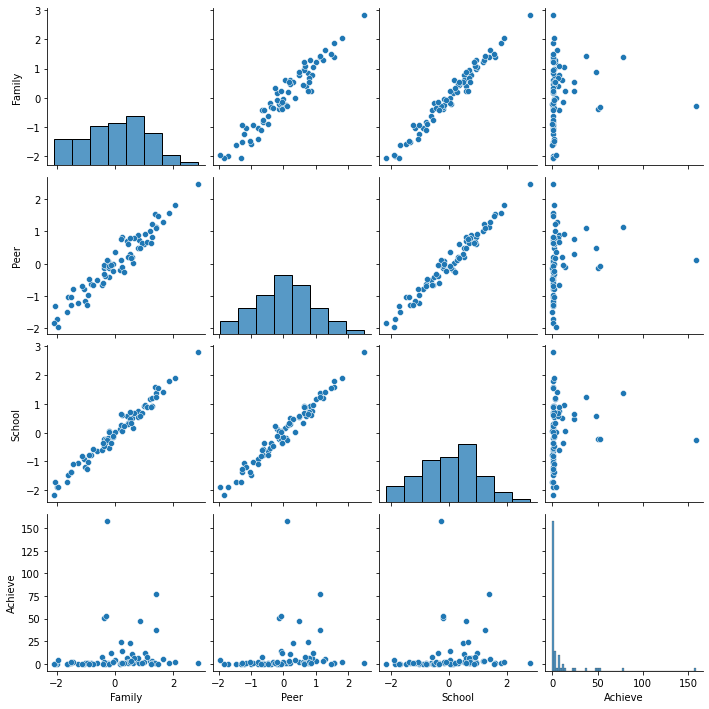

In [6]:
# Generate matrix of plots to visualise the pairwise relationships among multiple quantitive variables
sns.pairplot(df);

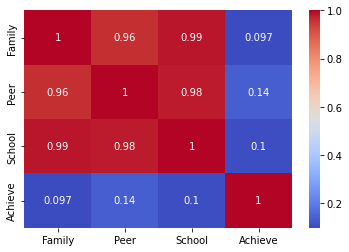

In [7]:
# Generate heatmap to understand correction between the predictors 
sns.heatmap(df.corr(), annot=True, cmap='coolwarm');

#  Model 1 #

In [8]:
# Fit additive Model 1 containing the 3 predictors Family, Peer and School
# Shows the model summary
mlr1 = ols('Achieve ~ Family + Peer + School',df).fit()
print(mlr1.summary())

# Shows MSE
print("\nMSE =", mlr1.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                Achieve   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9952
Date:                Sun, 31 Jul 2022   Prob (F-statistic):              0.401
Time:                        11:25:26   Log-Likelihood:                -317.11
No. Observations:                  70   AIC:                             642.2
Df Residuals:                      66   BIC:                             651.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1129      2.799      2.899      0.0

### Check Assumption - if Errors follow normal distribution ###

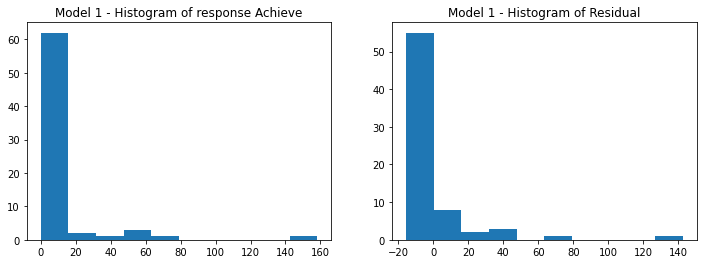

In [9]:
# Generate histogram to understand skewness

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121)
plt.hist(df.Achieve)  # the response Y
plt.title('Model 1 - Histogram of response Achieve');

ax = fig.add_subplot(122)
plt.hist(mlr1.resid)  # the residuals
plt.title('Model 1 - Histogram of Residual');


In [19]:
import warnings
warnings.filterwarnings('ignore')

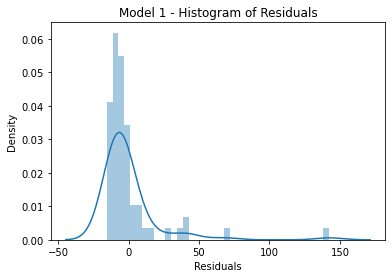

In [20]:
# Generate Histogram of the residuals to check normality visually
sns.distplot(mlr1.resid);  
plt.title('Model 1 - Histogram of Residuals')
plt.ylabel('Density')
plt.xlabel('Residuals');

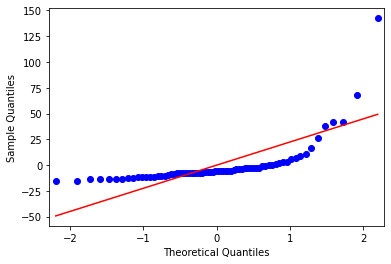

In [21]:
# Generate qqplot on Residuals
sm.qqplot(mlr1.resid, line='s');

In [22]:
# Conduct Shapiro-Wilk normality test. The function returns test statistics and P-value.

from scipy.stats import shapiro
shapiro(mlr1.resid)

ShapiroResult(statistic=0.5201622843742371, pvalue=9.035571498904743e-14)

In [23]:
# Two ways to to conduct Anderson-Darling normality test
# One uses the scipy library, and one uses the statsmodel library
#
# scipy: returns test statistic and critical values. Reject H0 if test statistic > critical value
# statsmodel: returns test statistics and P-value

# Method 1
from scipy.stats import anderson
anderson(mlr1.resid)

# Reject H0 if test statistics value > critical value

# Based on significance_level_array 5% location which is 3rd array or 0.748
# As test statistics = 10.235 which is > 0.783
# Thus, the conclusion is to reject H0
# ==> sufficent evidence at 5% level of significance to conclude that errors are not independent of each other


AndersonResult(statistic=10.234682421710161, critical_values=array([0.548, 0.624, 0.748, 0.873, 1.038]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [24]:
# Method 2
sm.stats.normal_ad(mlr1.resid)
# first value is computed test statistics value, second value is p-value
# since test statistics 10.235 is > 0, reject H0

(10.234682424987682, 5.85777828375381e-25)

### Check Assumption - if Errors have constant variance ###

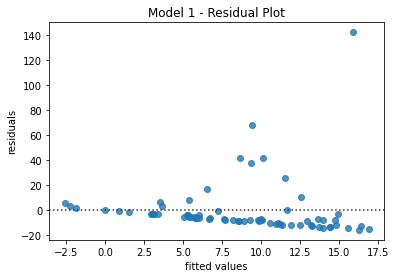

In [25]:
# Plot of residual vs fitted values 
sns.residplot(x=mlr1.fittedvalues, y=mlr1.resid)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.title ('Model 1 - Residual Plot');

In [26]:
# Conduct breusch pagan test to check if homoscedasticity
sm.stats.het_breuschpagan(mlr1.resid,mlr1.model.exog)

# The function returns: Lagrange multiplier statistic, 
# p-value, F-value, F p-value

(3.6497616165453293,
 0.30185163806417914,
 1.2101652913430962,
 0.3129811251261963)

### Check Assumption - if Errors are independent of each other

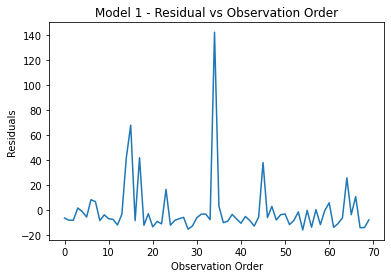

In [27]:
# Construct a line plot of residuals vs. observation order.
plt.plot(mlr1.resid)
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title ('Model 1 - Residual vs Observation Order');

In [28]:
# Perform the Durbin-Watson test on residuals.
sm.stats.durbin_watson(mlr1.resid)

1.9047333112358098

### Check Assumption - on little or no multicollinearity among the predictors
We can check for multicollinearity in the data set by:

Visually inspect the correlation matrix for correlated predictors.
Check the condition number. As a general rule of thumb, if the condition number is more than 30, the regression model may have multicolliearity problem. This is a matrix algebra method. In Statsmodel, summary output will automatically highlight multicollinearity issue if the condition number is too high.

Check the Variance Inflation Factor (VIF) method. As a rule of thumb, we interpret VIF for each predictor as follows:
VIF	Interpretation
VIF = 1	Not correlated
1<VIF<5	Moderately correlated
VIF > 5	Highly correlated


In [30]:
# Generate VIF for each predictor and term
print ("VIF for Model 1 :")
for i in range(3):
    predictor = mlr1.model.exog_names[i+1]
    VIF = vif(mlr1.model.exog, i+1)
    print ("   VIF for predictor",predictor,'is',VIF)

VIF for Model 1 :
   VIF for predictor Family is 37.580639932204285
   VIF for predictor Peer is 30.21165657710285
   VIF for predictor School is 83.15543705009657


### linearity ###

Text(0, 0.5, 'Peer')

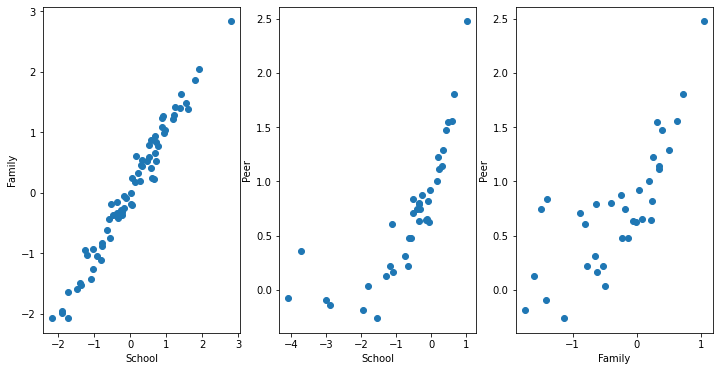

In [31]:
# Now seems nonlinearity is the major problem. We will explore transformation of the predictor.
# Plotting all scatterplots, with various transformed predictors, in a single figure.  
# Else, just plot one by one.  

fig = plt.figure(figsize=(12,6))

# Untransformed predictor
# 1 rows by 3 columns

ax = fig.add_subplot(131)
plt.scatter(df.School, df.Family)
plt.xlabel('School')
plt.ylabel('Family')

ax = fig.add_subplot(132)
plt.scatter(np.log(df.School), df.Peer)
plt.xlabel('School')
plt.ylabel('Peer')

ax = fig.add_subplot(133)
plt.scatter(np.log(df.Family), df.Peer)
plt.xlabel('Family')
plt.ylabel('Peer')

In [32]:
# Compute correlations of Y vs. different transformed X'
from scipy.stats import pearsonr
transformations = {'x':lambda x: x, 'lnx':lambda x: np.log(x), '1/x':lambda x: 1/x, 
                  'sqrt(x)':lambda x: np.sqrt(x), 'exp(-x/1000)':lambda x: np.exp(-x/1000)}
for tf in transformations:
    r_coef, r_pval = pearsonr(transformations[tf](df.Achieve), df.Family+df.Peer+df.School)
    print('Transformation: %s   Pearsons r: %0.3f    r_p_value: %0.3f' %(tf, r_coef, r_pval))

Transformation: x   Pearsons r: 0.112    r_p_value: 0.357
Transformation: lnx   Pearsons r: 0.429    r_p_value: 0.000
Transformation: 1/x   Pearsons r: -0.233    r_p_value: 0.052
Transformation: sqrt(x)   Pearsons r: 0.234    r_p_value: 0.051
Transformation: exp(-x/1000)   Pearsons r: -0.117    r_p_value: 0.335


# Model 2 #

In [40]:
# Fit SLR on transformed predictor. Then, produce a residual plot. 
mlr2 = ols('np.log(Achieve) ~ Family + Peer + School', df).fit()
print(mlr2.summary())
print("\nMSE =", mlr2.mse_resid)

                            OLS Regression Results                            
Dep. Variable:        np.log(Achieve)   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     5.717
Date:                Sun, 31 Jul 2022   Prob (F-statistic):            0.00153
Time:                        13:21:47   Log-Likelihood:                -148.20
No. Observations:                  70   AIC:                             304.4
Df Residuals:                      66   BIC:                             313.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0700      0.251     -0.279      0.7

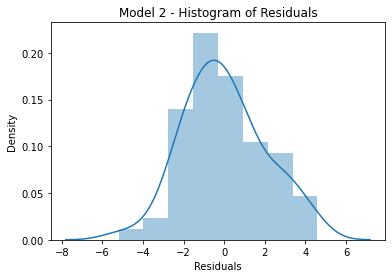

In [41]:
# Generate Histogram of the residuals to check normality 
sns.distplot(mlr2.resid);  
plt.title('Model 2 - Histogram of Residuals')
plt.ylabel('Density')
plt.xlabel('Residuals');

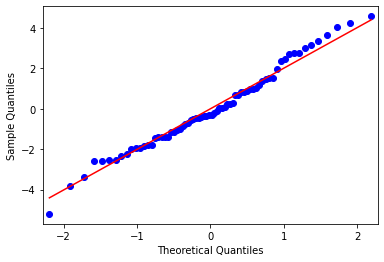

In [42]:
# Generate qqplot on Residuals
sm.qqplot(mlr2.resid, line='s');

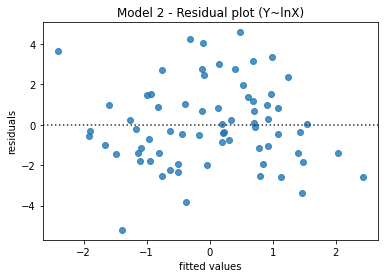

In [43]:
# Plot of residual vs fitted values 
sns.residplot(mlr2.fittedvalues, mlr2.resid)
plt.title('Model 2 - Residual plot (Y~lnX)')
plt.xlabel('fitted values')
plt.ylabel('residuals');

In [44]:
sm.stats.het_breuschpagan(mlr2.resid,mlr2.model.exog)

(0.38288774277761894,
 0.9437543538115123,
 0.12099798552379235,
 0.947429421660765)

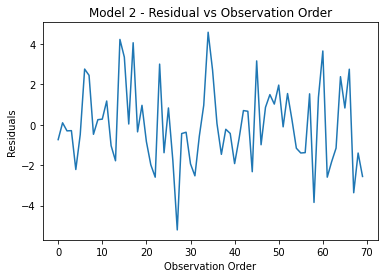

In [45]:
# Construct a line plot of residuals vs. observation order.
plt.plot(mlr2.resid)
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title ('Model 2 - Residual vs Observation Order');

In [46]:
# Perform the Durbin-Watson test on residuals.
sm.stats.durbin_watson(mlr2.resid)

1.7910242828969773

In [47]:
# Generate VIF for each predictor and term
print ("VIF for Model 2 :")
for i in range(3):
    predictor = mlr2.model.exog_names[i+1]
    VIF = vif(mlr2.model.exog, i+1)
    print ("   VIF for predictor",predictor,'is',VIF)

VIF for Model 2 :
   VIF for predictor Family is 37.580639932204285
   VIF for predictor Peer is 30.21165657710285
   VIF for predictor School is 83.15543705009657


### PCA ###

In [58]:
df.iloc[:,0:3]

,Family,Peer,School
0,0.60814,0.03509,0.16607
1,0.79369,0.47924,0.53356
2,-0.82630,-0.61951,-0.78635
3,-1.25310,-1.21675,-1.04076
4,0.17399,-0.18517,0.14229
...,...,...,...
65,0.53940,0.16182,0.33477
66,0.22491,0.74800,0.66182
67,1.48244,1.47079,1.54283
68,2.05425,1.80369,1.90066


In [59]:
# Create the PCA instance with 3 components, as p=3
pca3 = PCA(n_components=3)

# Then fit highly corrected predictor Family, Peer, School data to PCA, 
# i.e., to determine linear coefficients.
# Variables will be automatically centred by default.
pca3.fit(df.iloc[:,0:3])

print('Proportion of total variance:', pca3.explained_variance_ratio_)

print('\nPrincipal components are:\n', pca3.components_)

Proportion of total variance: [0.98445476 0.01286135 0.00268389]

Principal components are:
 [[ 0.61732371  0.5241853   0.5866355 ]
 [-0.67025631  0.74086406  0.04332342]
 [ 0.41190766  0.41994072 -0.80869145]]


In [60]:
# Compute and transform the original predictors to PC1,PC2 & PC3 scores.
newX = pca3.transform(df.iloc[:,0:3])

# Append PC1, PC2 & PC3 scores to (original) data frame
df['pc1'] = newX[:,0]
df['pc2'] = newX[:,1]
df['pc3'] = newX[:,2]
df.tail()

,Family,Peer,School,Achieve,pc1,pc2,pc3
65,0.53940,0.16182,0.33477,2.638842,0.540716,-0.229742,0.005424
66,0.22491,0.74800,0.66182,23.592527,0.845700,0.429496,-0.142438
67,1.48244,1.47079,1.54283,0.148375,2.517711,0.160286,-0.033389
68,2.05425,1.80369,1.90066,1.907856,3.255120,0.039163,0.052569
69,1.24058,0.64484,0.87372,0.172191,1.542930,-0.318511,0.061241


# Model 3 #

In [61]:
# Fit SLR model using PC1 score as the predictor.
slr3 = ols('Achieve ~ pc1', df).fit()
print(slr3.summary())
print("\nMSE =", slr3.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                Achieve   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8444
Date:                Sun, 31 Jul 2022   Prob (F-statistic):              0.361
Time:                        14:52:31   Log-Likelihood:                -318.23
No. Observations:                  70   AIC:                             640.5
Df Residuals:                      68   BIC:                             645.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6636      2.766      3.132      0.0

In [62]:
# Generate VIF for PC1
print ("VIF for Model 3 :")
print(slr3.model.exog_names[1], vif(slr3.model.exog,1))

VIF for Model 3 :
pc1 1.0


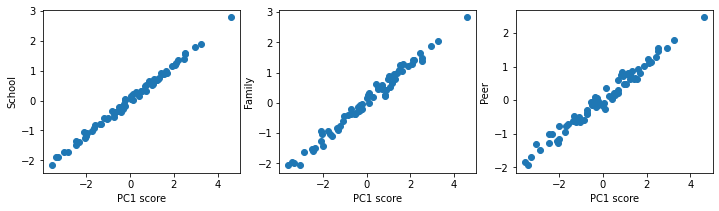

In [63]:
# Plot the (standardized) training data against PC1 to check correlation.
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(131)
plt.scatter(df.pc1, df.School)
plt.xlabel('PC1 score')
plt.ylabel('School')

ax = fig.add_subplot(132) 
plt.scatter(df.pc1, df.Family)
plt.xlabel('PC1 score')
plt.ylabel('Family')

ax = fig.add_subplot(133)
plt.scatter(df.pc1, df.Peer)
plt.xlabel('PC1 score')
plt.ylabel('Peer');



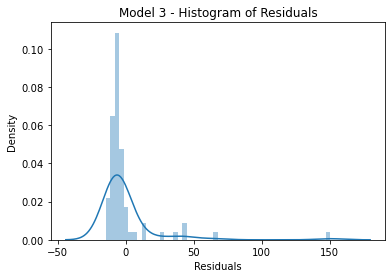

In [64]:
# Generate Histogram of the residuals to check normality visually
sns.distplot(slr3.resid);  
plt.title('Model 3 - Histogram of Residuals')
plt.ylabel('Density')
plt.xlabel('Residuals');

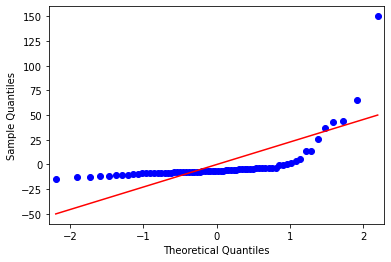

In [65]:
# Generate qqplot on Residuals
sm.qqplot(slr3.resid, line='s');

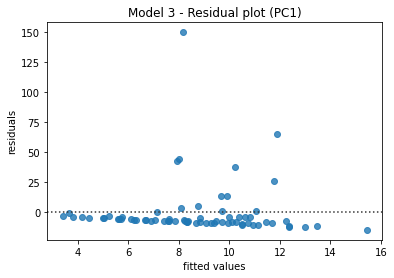

In [66]:
# Plot of residual vs fitted values 

sns.residplot(slr3.fittedvalues, slr3.resid)
plt.title('Model 3 - Residual plot (PC1)')
plt.xlabel('fitted values')
plt.ylabel('residuals');

In [67]:
sm.stats.het_breuschpagan(slr3.resid,mlr2.model.exog)

(3.3178280764831944,
 0.34516900652501203,
 1.0946286777573921,
 0.3576715221602523)

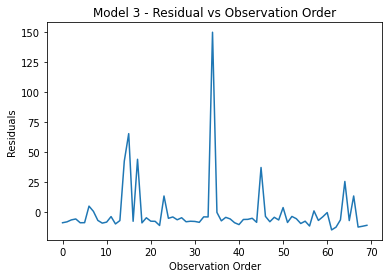

In [68]:
# Construct a line plot of residuals vs. observation order. Type: plt.plot(residname);
plt.plot(slr3.resid)
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.title ('Model 3 - Residual vs Observation Order');

In [69]:
# Perform the Durbin-Watson test on residuals
sm.stats.durbin_watson(slr3.resid)

1.9035874653846006

In [70]:
np.mean(df.Family)

0.04938328571428575

In [71]:
np.mean(df.Peer)

0.04631414285714283

In [72]:
np.mean(df.School)

0.03190642857142852